In [16]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
from itertools import groupby
from torch.utils.data import random_split, DataLoader
import cv2
def get_frames_between(video_path, start_frame, end_frame,num_frames):
    """
    Extract frames between two specific frame indices from a video.

    Args:
        video_path (str): Path to the video file.
        start_frame (int): The starting frame index (inclusive).
        end_frame (int): The ending frame index (exclusive).

    Returns:
        torch.Tensor: A tensor of frames in shape (N, H, W, C), where N is the number of frames.
    """
   
    cap = cv2.VideoCapture(video_path)
    if end_frame<0 :
        end_frame=int(cap.get(cv2.CAP_PROP_FRAME_COUNT))-1
        start_frame=max(end_frame-num_frames,0)
    frames = []

    # Set the starting frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    # Read frames up to the end_frame
    for i in range(start_frame, end_frame):
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (224, 224)) 
        # print(frame.shape) # Resize frames if necessary
        frames.append(frame)

    cap.release()
    
    # Convert to a single tensor (N, H, W, C)
    # if frames:
    #     frames = torch.stack(frames)
    # print(video_path)
    return frames
class CrashFrameDataset(Dataset):
    def __init__(self, crash_dir, non_crash_dir,label_csv, num_frames=16, resize=(224, 224)):
        """
        Args:
            image_folder: Path to the folder containing all images.
            label_csv: Path to the CSV file with crash frame labels.
            num_frames: Number of frames to sample before the crash.
            resize: Target size for frames (H, W).
        """
        # self.image_folder = image_folder
        # self.num_frames = num_frames
        self.resize = resize
        self.transform = transforms.Compose([
            transforms.Resize(resize),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.num_frames=num_frames
        # Load crash table
        self.label_data = pd.read_csv(label_csv)
        # self.image_data = self._prepare_image_data()
        self.crash_videos = [(os.path.join(crash_dir, f), 1,f) for f in os.listdir(crash_dir)[:500] if f.endswith('.mp4')]
        self.non_crash_videos = [(os.path.join(non_crash_dir, f), 0,f) for f in os.listdir(non_crash_dir)[:500] if f.endswith('.mp4')]
        self.all_videos = self.crash_videos + self.non_crash_videos
    def _prepare_image_data(self):
        """
        Prepare a list of dictionaries with frame metadata and labels.
        """
        image_data = []
        for filename in os.listdir(self.image_folder):
            if filename.endswith(('.jpg', '.png')):
                # Parse metadata from filename
                crash_or_normal = filename[0]  # 'C' or 'N'
                video_id = int(filename[2:8])  # e.g., '000001'
                frame_number = int(filename[9:11])  # Frame number (01 to 50)
                label_row = self.label_data[self.label_data['vidname'] == video_id]
                label = label_row[f'frame_{frame_number}'].values[0]
                print(crash_or_normal)
                # if label ==1:
                    
                image_data.append({
                    'filename': filename,
                    'crash_or_normal': crash_or_normal,
                    'video_id': video_id,
                    'frame_number': frame_number,
                    'label': label
                })
                
        grouped_frames = []
        sorted_image_data= sorted(image_data, key=lambda x: (x['video_id'], x['frame_number']))
        for _, group in groupby(sorted_image_data, key=lambda x: x['video_id']):
            frames = [frame for frame in group]  # Assuming 'frame_data' contains the frame image data
            grouped_frames.append(frames)
        # print(len(grouped_frames))
        return grouped_frames

    def __len__(self):
        # Number of sequences in the dataset
        return len(self.all_videos)

    def __getitem__(self, idx):
        """
        Load a sequence of 16 frames and return its label (0 for normal, 1 for crash).
        """
        frames = self.all_videos[idx]
        # print(len(frames))
        video_id = frames[2].split('.')[0]
        crash_or_normal=frames[1]
        # Find the start and end indices for the frame sequence
        begin=0
        # print(crash_or_normal)
        if int(crash_or_normal)==1:
            label_row = self.label_data[self.label_data['vidname'] == int(video_id)]
            # print("ok")
            for  frame_number in range (50) :
                label = label_row[f'frame_{frame_number+1}'].values[0]
                # print(l['label'])
                if int(label)==1:
                    begin =frame_number-1
                    # print(begin)
                    break
        else:
            begin=-1
        start_idx = max(begin - self.num_frames, 0)
        end_idx = begin
        
        # print(frames)
        # Get frames in this range
        frames = get_frames_between(video_path=frames[0], start_frame=start_idx, end_frame=end_idx,num_frames=self.num_frames)
        
        # frames = []
        # crash_label = (crash_or_normal=='C' or crash_or_normal=='c')  # Default is normal (0)
        processed_frames=[]
        for frame in frames:
            processed_frames.append(torch.tensor(self.transform(Image.fromarray(frame))))
        #     frame_path = os.path.join(self.image_folder, frame_info['filename'])
        #     image = Image.open(frame_path).convert('RGB')
        #     frames.append(self.transform(image))
        #     # If any of the frames have a crash label (1), set the crash label to 1
        #     # if frame_info['label'] == 1:
        #     #     crash_label = 1
        
        # Pad if not enough frames before the crash
        while len(processed_frames) < self.num_frames:
            processed_frames.insert(0, frames[0])  # Duplicate the first frame

        frames = torch.stack(processed_frames)  # Shape: [T, C, H, W]
        # converted_tensor =  frames.permute(3, 1, 0, 2)
        converted_tensor=frames.permute(1, 0, 2, 3)
        return converted_tensor, crash_or_normal  # Shape: [C, T, H, W]

# Example Usage
crash_dir = '/home/baklava/crash_data/crashed'
non_crash_dir ='/home/baklava/crash_data/nocrashed'
label_csv='/home/baklava/donut/Crash_Table.csv'
dataset = CrashFrameDataset(crash_dir=crash_dir,non_crash_dir=non_crash_dir, label_csv=label_csv, num_frames=16)
# Define split ratios
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Compute lengths for each split
total_length = len(dataset)
train_length = int(train_ratio * total_length)
val_length = int(val_ratio * total_length)
test_length = total_length - train_length - val_length  # Ensure no samples are missed

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_length, val_length, test_length])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
# DataLoader
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)

# for batch in dataloader:
#     videos, labels = batch  # videos: [B, C, T, H, W], labels: [B]
#     print(videos.shape, labels.shape)


In [93]:
dataset[20][0].shape

/tmp/ipykernel_1708985/773179043.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  processed_frames.append(torch.tensor(self.transform(Image.fromarray(frame))))


torch.Size([3, 16, 224, 224])

Sequence Label: 1
Frames Shape: torch.Size([3, 16, 224, 224])


/tmp/ipykernel_1849282/1045363130.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  processed_frames.append(torch.tensor(self.transform(Image.fromarray(frame))))


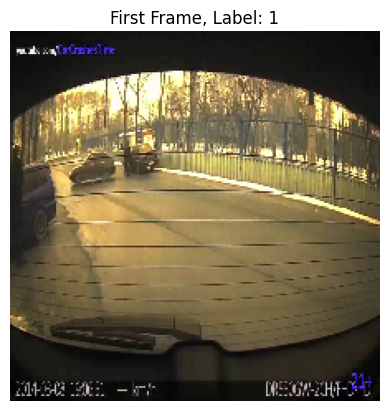

In [68]:
# Get the first item from the dataset
frames, label = dataset[0]

# Print label
print("Sequence Label:", label)  # 0 or 1

# Print the shape of the frames
print("Frames Shape:", frames.shape)  # [C, T, H, W]

# Inspect the first frame in the sequence
first_frame = frames[:, 15, :, :]  # Extract the first frame (shape: [C, H, W])

# Convert the first frame to a numpy array for visualization
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

# Denormalize the image for display
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
denormalized_frame = first_frame * std + mean  # Reverse normalization

# Convert to numpy for display
frame_np = denormalized_frame.permute(1, 2, 0).numpy()  # [H, W, C]

# Plot the frame
plt.imshow(frame_np)
plt.title(f"First Frame, Label: {label}")
plt.axis('off')
plt.show()


In [15]:
import torch
import torch.nn as nn
from torchvision.models.video import swin3d_b

class VideoSwinCrashPredictor(nn.Module):
    def __init__(self, num_classes=1):
        super(VideoSwinCrashPredictor, self).__init__()
        # Load pretrained Video Swin Transformer
        self.swin3d = swin3d_b(pretrained=True)
        
        # Replace the classification head to match our binary task
        self.swin3d.head = nn.Sequential(
            nn.Linear(self.swin3d.head.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes),
            nn.Sigmoid()  # Binary output
        )

    def forward(self, x):
        """
        x: Video Tensor of shape [B, C, T, H, W]
           B: Batch size
           C: Number of channels (e.g., 3 for RGB)
           T: Number of frames
           H, W: Height and width of each frame
        """
        return self.swin3d(x)

# Example usage
if __name__ == "__main__":
    # Initialize the model
    model = VideoSwinCrashPredictor()
    
    # Dummy input: batch of 4 videos, each with 16 frames of size 224x224
    video_input = torch.randn(4, 3, 16, 224, 224)
    
    # Forward pass
    output = model(video_input)
    print("Output shape:", output.shape)  # Expected: [4, 1]


/home/baklava/miniconda3/envs/donut310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/baklava/miniconda3/envs/donut310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Swin3D_B_Weights.KINETICS400_V1`. You can also use `weights=Swin3D_B_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Output shape: torch.Size([4, 1])


In [17]:
# Initialize history dictionary
# Define loss function and optimizer
from tqdm import tqdm
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
history = {
    "train_loss": [],
    "val_loss": [],
    "test_loss": 0.0,
    "test_accuracy": 0.0
}
device ='cuda'

# Training and validation loop
num_epochs = 5
model=model.to(device)
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1} - Training") as pbar:
        for video_batch, labels in train_loader:
            video_batch = video_batch.to(device)
            labels = labels.to(device)
            
            outputs = model(video_batch).squeeze()
            
            loss = criterion(outputs, labels.float())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            pbar.set_postfix({"Batch Loss": loss.item()})
            pbar.update(1)
    
    avg_train_loss = train_loss / len(train_loader)
    history["train_loss"].append(avg_train_loss)
    print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}")

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        with tqdm(total=len(val_loader), desc=f"Epoch {epoch+1} - Validation") as pbar:
            for video_batch, labels in val_loader:
                video_batch = video_batch.to(device)
                labels = labels.to(device)
                outputs = model(video_batch).squeeze()
            
            # Reshape outputs to match labels
                outputs = outputs.view_as(labels)
                
                loss = criterion(outputs, labels.float())
                val_loss += loss.item()
                pbar.set_postfix({"Batch Loss": loss.item()})
                pbar.update(1)
    
    avg_val_loss = val_loss / len(val_loader)
    history["val_loss"].append(avg_val_loss)
    print(f"Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}")

# Test phase
model.eval()
test_loss = 0.0
correct_predictions = 0
total_predictions = 0
with torch.no_grad():
    with tqdm(total=len(test_loader), desc="Testing") as pbar:
        for video_batch, labels in test_loader:
            video_batch = video_batch.to(device)
            labels = labels.to(device)
            
            outputs = model(video_batch).squeeze()
            outputs = outputs.view_as(labels)
            loss = criterion(outputs, labels.float())
            test_loss += loss.item()
            
            predictions = (outputs > 0.5).float()
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)
            pbar.update(1)

history["test_loss"] = test_loss / len(test_loader)
history["test_accuracy"] = correct_predictions / total_predictions
print(f"Test Loss: {history['test_loss']:.4f}, Test Accuracy: {history['test_accuracy']:.2%}")


Epoch 1 - Training:   0%|          | 0/175 [00:00<?, ?it/s]/tmp/ipykernel_1849282/1045363130.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  processed_frames.append(torch.tensor(self.transform(Image.fromarray(frame))))
Epoch 1 - Training: 100%|██████████| 175/175 [03:31<00:00,  1.21s/it, Batch Loss=0.658]


Epoch 1, Training Loss: 0.6746


Epoch 1 - Validation: 100%|██████████| 200/200 [00:27<00:00,  7.28it/s, Batch Loss=0.572]


Epoch 1, Validation Loss: 0.6363


Epoch 2 - Training: 100%|██████████| 175/175 [03:32<00:00,  1.21s/it, Batch Loss=0.385]


Epoch 2, Training Loss: 0.5758


Epoch 2 - Validation: 100%|██████████| 200/200 [00:27<00:00,  7.27it/s, Batch Loss=0.41] 


Epoch 2, Validation Loss: 0.4717


Epoch 3 - Training: 100%|██████████| 175/175 [03:32<00:00,  1.22s/it, Batch Loss=0.212]


Epoch 3, Training Loss: 0.3571


Epoch 3 - Validation: 100%|██████████| 200/200 [00:27<00:00,  7.27it/s, Batch Loss=0.191]


Epoch 3, Validation Loss: 0.2138


Epoch 4 - Training: 100%|██████████| 175/175 [03:32<00:00,  1.22s/it, Batch Loss=0.123] 


Epoch 4, Training Loss: 0.1609


Epoch 4 - Validation: 100%|██████████| 200/200 [00:27<00:00,  7.26it/s, Batch Loss=0.076] 


Epoch 4, Validation Loss: 0.0912


Epoch 5 - Training: 100%|██████████| 175/175 [03:32<00:00,  1.22s/it, Batch Loss=0.0386]


Epoch 5, Training Loss: 0.0833


Epoch 5 - Validation: 100%|██████████| 200/200 [00:27<00:00,  7.27it/s, Batch Loss=0.039] 


Epoch 5, Validation Loss: 0.0545


Testing: 100%|██████████| 100/100 [00:13<00:00,  7.33it/s]

Test Loss: 0.0588, Test Accuracy: 99.00%


In [98]:
import json

# Save to a file
with open("training_history.json", "w") as f:
    json.dump(history, f)

# Load the history later
with open("training_history.json", "r") as f:
    loaded_history = json.load(f)

In [99]:
loaded_history

{'train_loss': [0.5859538238389151],
 'val_loss': [0.5068558505177498],
 'test_loss': 0.5133870479464531,
 'test_accuracy': 0.94}

In [100]:
torch.save(model, 'crash_predector_model.pth')  # Saves the entire model including the architecture


In [101]:
model

VideoSwinCrashPredictor(
  (swin3d): SwinTransformer3d(
    (patch_embed): PatchEmbed3d(
      (proj): Conv3d(3, 128, kernel_size=(2, 4, 4), stride=(2, 4, 4))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (features): Sequential(
      (0): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): ShiftedWindowAttention3d(
            (qkv): Linear(in_features=128, out_features=384, bias=True)
            (proj): Linear(in_features=128, out_features=128, bias=True)
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (mlp): MLP(
            (0): Linear(in_features=128, out_features=512, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=512, out

Testing:   0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_1849282/1045363130.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  processed_frames.append(torch.tensor(self.transform(Image.fromarray(frame))))
Testing: 100%|██████████| 100/100 [00:13<00:00,  7.38it/s]


Test Loss: 0.0588, Test Accuracy: 99.00%
Test Precision: 1.0000
Test Recall: 0.9808
Test F1 Score: 0.9903
Confusion Matrix:
[[48  0]
 [ 1 51]]


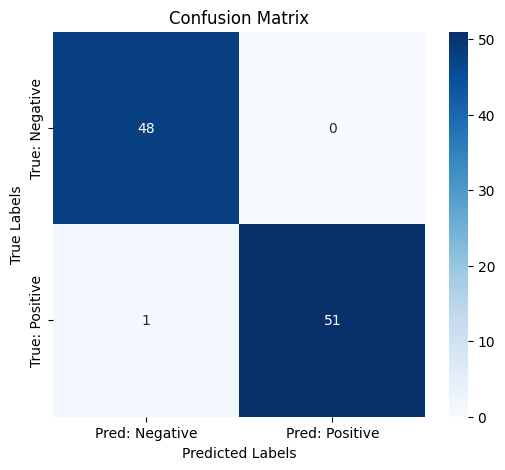

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# Test phase
model.eval()
test_loss = 0.0
correct_predictions = 0
total_predictions = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    with tqdm(total=len(test_loader), desc="Testing") as pbar:
        for video_batch, labels in test_loader:
            video_batch = video_batch.to(device)
            labels = labels.to(device)
            
            outputs = model(video_batch).squeeze()
            outputs = outputs.view_as(labels)
            loss = criterion(outputs, labels.float())
            test_loss += loss.item()
            
            # Collecting predictions and true labels for F1, precision, recall, and confusion matrix
            predictions = (outputs > 0.5).float()
            all_labels.append(labels.cpu().numpy())
            all_predictions.append(predictions.cpu().numpy())
            
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)
            pbar.update(1)

# Calculate the average test loss
history["test_loss"] = test_loss / len(test_loader)

# Calculate accuracy
history["test_accuracy"] = correct_predictions / total_predictions

# Flatten the list of labels and predictions for F1, precision, recall, and confusion matrix
all_labels = np.concatenate(all_labels)
all_predictions = np.concatenate(all_predictions)

# Calculate precision, recall, and F1 score
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

history["test_precision"] = precision
history["test_recall"] = recall
history["test_f1"] = f1
history["test_confusion_matrix"] = conf_matrix

# Print results
print(f"Test Loss: {history['test_loss']:.4f}, Test Accuracy: {history['test_accuracy']:.2%}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Pred: Negative", "Pred: Positive"], yticklabels=["True: Negative", "True: Positive"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [36]:
model.eval()
video_batch,labels=dataset[600]
# print(video_batch)
video_batch = video_batch.to(device)
video_batch=video_batch.unsqueeze(0)
# labels = labels.to(device)

# outputs = model([video_batch]).squeeze()
outputs = model(video_batch).squeeze()
predictions =int((outputs > 0.5))
# outputs = outputs.view_as(labels)
print(predictions,labels)

0 0


/tmp/ipykernel_1849282/1045363130.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  processed_frames.append(torch.tensor(self.transform(Image.fromarray(frame))))


In [104]:
!pip install seaborn

In [6]:
import torch
import torch.nn as nn
from torchvision.models.video import r3d_18

class VideoR3DCrashPredictor(nn.Module):
    def __init__(self, num_classes=1):
        super(VideoR3DCrashPredictor, self).__init__()
        # Load pretrained R3D model
        self.r3d = r3d_18(pretrained=True)  # ResNet-3D with 18 layers
        
        # Replace the classification head to match our binary task
        self.r3d.fc = nn.Sequential(
            nn.Linear(self.r3d.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes),
            nn.Sigmoid()  # Binary output
        )

    def forward(self, x):
        """
        x: Video Tensor of shape [B, C, T, H, W]
           B: Batch size
           C: Number of channels (e.g., 3 for RGB)
           T: Number of frames
           H, W: Height and width of each frame
        """
        return self.r3d(x)

# Example usage
if __name__ == "__main__":
    # Initialize the model
    model = VideoR3DCrashPredictor()
    
    # Dummy input: batch of 4 videos, each with 16 frames of size 112x112
    # video_input = torch.randn(4, 3, 16, 112, 112)  # R3D typically uses 112x112 frame size
    
    # # Forward pass
    # output = model(video_input)
    # print("Output shape:", output.shape)  # Expected: [4, 1]


In [7]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
from itertools import groupby
from torch.utils.data import random_split, DataLoader
import cv2
def get_frames_between(video_path, start_frame, end_frame,num_frames):
    """
    Extract frames between two specific frame indices from a video.

    Args:
        video_path (str): Path to the video file.
        start_frame (int): The starting frame index (inclusive).
        end_frame (int): The ending frame index (exclusive).

    Returns:
        torch.Tensor: A tensor of frames in shape (N, H, W, C), where N is the number of frames.
    """
   
    cap = cv2.VideoCapture(video_path)
    if end_frame<0 :
        end_frame=int(cap.get(cv2.CAP_PROP_FRAME_COUNT))-1
        start_frame=max(end_frame-num_frames,0)
    frames = []

    # Set the starting frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    # Read frames up to the end_frame
    for i in range(start_frame, end_frame):
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (224, 224)) 
        # print(frame.shape) # Resize frames if necessary
        frames.append(frame)

    cap.release()
    
    # Convert to a single tensor (N, H, W, C)
    # if frames:
    #     frames = torch.stack(frames)
    # print(video_path)
    return frames
class CrashFrameDataset(Dataset):
    def __init__(self, crash_dir, non_crash_dir,label_csv, num_frames=16, resize=(224, 224)):
        """
        Args:
            image_folder: Path to the folder containing all images.
            label_csv: Path to the CSV file with crash frame labels.
            num_frames: Number of frames to sample before the crash.
            resize: Target size for frames (H, W).
        """
        # self.image_folder = image_folder
        # self.num_frames = num_frames
        self.resize = resize
        self.transform = transforms.Compose([
            transforms.Resize((112, 112)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.num_frames=num_frames
        # Load crash table
        self.label_data = pd.read_csv(label_csv)
        # self.image_data = self._prepare_image_data()
        self.crash_videos = [(os.path.join(crash_dir, f), 1,f) for f in os.listdir(crash_dir)[:500] if f.endswith('.mp4')]
        self.non_crash_videos = [(os.path.join(non_crash_dir, f), 0,f) for f in os.listdir(non_crash_dir)[:500] if f.endswith('.mp4')]
        self.all_videos = self.crash_videos + self.non_crash_videos
    def _prepare_image_data(self):
        """
        Prepare a list of dictionaries with frame metadata and labels.
        """
        image_data = []
        for filename in os.listdir(self.image_folder):
            if filename.endswith(('.jpg', '.png')):
                # Parse metadata from filename
                crash_or_normal = filename[0]  # 'C' or 'N'
                video_id = int(filename[2:8])  # e.g., '000001'
                frame_number = int(filename[9:11])  # Frame number (01 to 50)
                label_row = self.label_data[self.label_data['vidname'] == video_id]
                label = label_row[f'frame_{frame_number}'].values[0]
                print(crash_or_normal)
                # if label ==1:
                    
                image_data.append({
                    'filename': filename,
                    'crash_or_normal': crash_or_normal,
                    'video_id': video_id,
                    'frame_number': frame_number,
                    'label': label
                })
                
        grouped_frames = []
        sorted_image_data= sorted(image_data, key=lambda x: (x['video_id'], x['frame_number']))
        for _, group in groupby(sorted_image_data, key=lambda x: x['video_id']):
            frames = [frame for frame in group]  # Assuming 'frame_data' contains the frame image data
            grouped_frames.append(frames)
        # print(len(grouped_frames))
        return grouped_frames

    def __len__(self):
        # Number of sequences in the dataset
        return len(self.all_videos)

    def __getitem__(self, idx):
        """
        Load a sequence of 16 frames and return its label (0 for normal, 1 for crash).
        """
        frames = self.all_videos[idx]
        # print(len(frames))
        video_id = frames[2].split('.')[0]
        crash_or_normal=frames[1]
        # Find the start and end indices for the frame sequence
        begin=0
        # print(crash_or_normal)
        if int(crash_or_normal)==1:
            label_row = self.label_data[self.label_data['vidname'] == int(video_id)]
            # print("ok")
            for  frame_number in range (50) :
                label = label_row[f'frame_{frame_number+1}'].values[0]
                # print(l['label'])
                if int(label)==1:
                    begin =frame_number-1
                    # print(begin)
                    break
        else:
            begin=-1
        start_idx = max(begin - self.num_frames, 0)
        end_idx = begin
        
        # print(frames)
        # Get frames in this range
        frames = get_frames_between(video_path=frames[0], start_frame=start_idx, end_frame=end_idx,num_frames=self.num_frames)
        
        # frames = []
        # crash_label = (crash_or_normal=='C' or crash_or_normal=='c')  # Default is normal (0)
        processed_frames=[]
        for frame in frames:
            processed_frames.append(torch.tensor(self.transform(Image.fromarray(frame))))
        #     frame_path = os.path.join(self.image_folder, frame_info['filename'])
        #     image = Image.open(frame_path).convert('RGB')
        #     frames.append(self.transform(image))
        #     # If any of the frames have a crash label (1), set the crash label to 1
        #     # if frame_info['label'] == 1:
        #     #     crash_label = 1
        
        # Pad if not enough frames before the crash
        while len(processed_frames) < self.num_frames:
            processed_frames.insert(0, frames[0])  # Duplicate the first frame

        frames = torch.stack(processed_frames)  # Shape: [T, C, H, W]
        # converted_tensor =  frames.permute(3, 1, 0, 2)
        converted_tensor=frames.permute(1, 0, 2, 3)
        return converted_tensor, crash_or_normal  # Shape: [C, T, H, W]

# Example Usage
crash_dir = '/home/baklava/crash_data/crashed'
non_crash_dir ='/home/baklava/crash_data/nocrashed'
label_csv='/home/baklava/donut/Crash_Table.csv'
dataset = CrashFrameDataset(crash_dir=crash_dir,non_crash_dir=non_crash_dir, label_csv=label_csv, num_frames=16)
# Define split ratios
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Compute lengths for each split
total_length = len(dataset)
train_length = int(train_ratio * total_length)
val_length = int(val_ratio * total_length)
test_length = total_length - train_length - val_length  # Ensure no samples are missed

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_length, val_length, test_length])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
# DataLoader
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)

# for batch in dataloader:
#     videos, labels = batch  # videos: [B, C, T, H, W], labels: [B]
#     print(videos.shape, labels.shape)


In [8]:
# Initialize history dictionary
# Define loss function and optimizer
from tqdm import tqdm
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
history = {
    "train_loss": [],
    "val_loss": [],
    "test_loss": 0.0,
    "test_accuracy": 0.0
}
device ='cuda'

# Training and validation loop
num_epochs = 5
model=model.to(device)
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1} - Training") as pbar:
        for video_batch, labels in train_loader:
            video_batch = video_batch.to(device)
            labels = labels.to(device)
            
            outputs = model(video_batch).squeeze()
            
            loss = criterion(outputs, labels.float())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            pbar.set_postfix({"Batch Loss": loss.item()})
            pbar.update(1)
    
    avg_train_loss = train_loss / len(train_loader)
    history["train_loss"].append(avg_train_loss)
    print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}")

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        with tqdm(total=len(val_loader), desc=f"Epoch {epoch+1} - Validation") as pbar:
            for video_batch, labels in val_loader:
                video_batch = video_batch.to(device)
                labels = labels.to(device)
                outputs = model(video_batch).squeeze()
            
            # Reshape outputs to match labels
                outputs = outputs.view_as(labels)
                
                loss = criterion(outputs, labels.float())
                val_loss += loss.item()
                pbar.set_postfix({"Batch Loss": loss.item()})
                pbar.update(1)
    
    avg_val_loss = val_loss / len(val_loader)
    history["val_loss"].append(avg_val_loss)
    print(f"Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}")

# Test phase
model.eval()
test_loss = 0.0
correct_predictions = 0
total_predictions = 0
with torch.no_grad():
    with tqdm(total=len(test_loader), desc="Testing") as pbar:
        for video_batch, labels in test_loader:
            video_batch = video_batch.to(device)
            labels = labels.to(device)
            
            outputs = model(video_batch).squeeze()
            outputs = outputs.view_as(labels)
            loss = criterion(outputs, labels.float())
            test_loss += loss.item()
            
            predictions = (outputs > 0.5).float()
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)
            pbar.update(1)

history["test_loss"] = test_loss / len(test_loader)
history["test_accuracy"] = correct_predictions / total_predictions
print(f"Test Loss: {history['test_loss']:.4f}, Test Accuracy: {history['test_accuracy']:.2%}")


Epoch 1 - Training:   0%|          | 0/175 [00:00<?, ?it/s]

/tmp/ipykernel_1849282/3155098164.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  processed_frames.append(torch.tensor(self.transform(Image.fromarray(frame))))
Epoch 1 - Training: 100%|██████████| 175/175 [00:56<00:00,  3.09it/s, Batch Loss=0.725]


Epoch 1, Training Loss: 0.6812


Epoch 1 - Validation: 100%|██████████| 200/200 [00:13<00:00, 15.28it/s, Batch Loss=0.744]


Epoch 1, Validation Loss: 0.6724


Epoch 2 - Training: 100%|██████████| 175/175 [00:56<00:00,  3.08it/s, Batch Loss=0.681]


Epoch 2, Training Loss: 0.6535


Epoch 2 - Validation: 100%|██████████| 200/200 [00:13<00:00, 15.37it/s, Batch Loss=0.697]


Epoch 2, Validation Loss: 0.6396


Epoch 3 - Training: 100%|██████████| 175/175 [00:57<00:00,  3.07it/s, Batch Loss=0.591]


Epoch 3, Training Loss: 0.6240


Epoch 3 - Validation: 100%|██████████| 200/200 [00:13<00:00, 15.32it/s, Batch Loss=0.697]


Epoch 3, Validation Loss: 0.6111


Epoch 4 - Training: 100%|██████████| 175/175 [00:56<00:00,  3.08it/s, Batch Loss=0.682]


Epoch 4, Training Loss: 0.6050


Epoch 4 - Validation: 100%|██████████| 200/200 [00:13<00:00, 15.37it/s, Batch Loss=0.667]


Epoch 4, Validation Loss: 0.5769


Epoch 5 - Training: 100%|██████████| 175/175 [00:56<00:00,  3.09it/s, Batch Loss=0.548]


Epoch 5, Training Loss: 0.5742


Epoch 5 - Validation: 100%|██████████| 200/200 [00:12<00:00, 15.46it/s, Batch Loss=0.66] 


Epoch 5, Validation Loss: 0.5459


Testing: 100%|██████████| 100/100 [00:06<00:00, 15.42it/s]

Test Loss: 0.5451, Test Accuracy: 81.00%


Testing:   0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_1849282/3155098164.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  processed_frames.append(torch.tensor(self.transform(Image.fromarray(frame))))
Testing: 100%|██████████| 100/100 [00:06<00:00, 15.25it/s]


Test Loss: 0.5451, Test Accuracy: 81.00%
Test Precision: 0.7463
Test Recall: 0.9615
Test F1 Score: 0.8403
Confusion Matrix:
[[31 17]
 [ 2 50]]


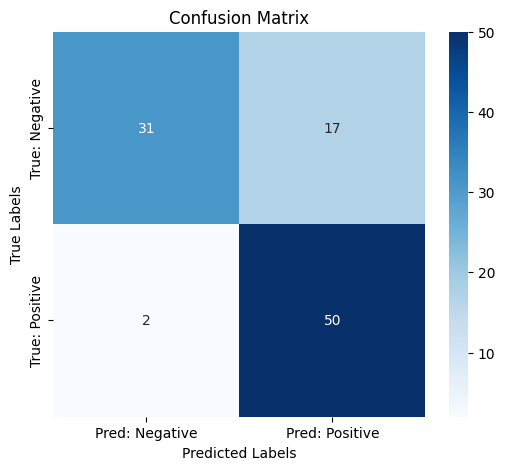

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# Test phase
model.eval()
test_loss = 0.0
correct_predictions = 0
total_predictions = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    with tqdm(total=len(test_loader), desc="Testing") as pbar:
        for video_batch, labels in test_loader:
            video_batch = video_batch.to(device)
            labels = labels.to(device)
            
            outputs = model(video_batch).squeeze()
            outputs = outputs.view_as(labels)
            loss = criterion(outputs, labels.float())
            test_loss += loss.item()
            
            # Collecting predictions and true labels for F1, precision, recall, and confusion matrix
            predictions = (outputs > 0.5).float()
            all_labels.append(labels.cpu().numpy())
            all_predictions.append(predictions.cpu().numpy())
            
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)
            pbar.update(1)

# Calculate the average test loss
history["test_loss"] = test_loss / len(test_loader)

# Calculate accuracy
history["test_accuracy"] = correct_predictions / total_predictions

# Flatten the list of labels and predictions for F1, precision, recall, and confusion matrix
all_labels = np.concatenate(all_labels)
all_predictions = np.concatenate(all_predictions)

# Calculate precision, recall, and F1 score
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

history["test_precision"] = precision
history["test_recall"] = recall
history["test_f1"] = f1
history["test_confusion_matrix"] = conf_matrix

# Print results
print(f"Test Loss: {history['test_loss']:.4f}, Test Accuracy: {history['test_accuracy']:.2%}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Pred: Negative", "Pred: Positive"], yticklabels=["True: Negative", "True: Positive"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [11]:
import torch
import torch.nn as nn
from torchvision.models.video import mc3_18

class VideoMC3CrashPredictor(nn.Module):
    def __init__(self, num_classes=1):
        super(VideoMC3CrashPredictor, self).__init__()
        # Load pretrained MC3 model
        self.mc3 = mc3_18(pretrained=True)
        
        # Replace the classification head
        self.mc3.fc = nn.Sequential(
            nn.Linear(self.mc3.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes),
            nn.Sigmoid()  # Binary output for crash prediction
        )

    def forward(self, x):
        """
        x: Video Tensor of shape [B, C, T, H, W]
           B: Batch size
           C: Number of channels (e.g., 3 for RGB)
           T: Number of frames
           H, W: Height and width of each frame
        """
        return self.mc3(x)

# Example usage
if __name__ == "__main__":
    # Initialize the model
    model = VideoMC3CrashPredictor()
    
    # Dummy input: batch of 4 videos, each with 16 frames of size 224x224
    video_input = torch.randn(4, 3, 16, 224, 224)
    
    # Forward pass
    output = model(video_input)
    print("Output shape:", output.shape)  # Expected: [4, 1]


/home/baklava/miniconda3/envs/donut310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/baklava/miniconda3/envs/donut310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MC3_18_Weights.KINETICS400_V1`. You can also use `weights=MC3_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mc3_18-a90a0ba3.pth" to /root/.cache/torch/hub/checkpoints/mc3_18-a90a0ba3.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 170MB/s]


Output shape: torch.Size([4, 1])


In [12]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
from itertools import groupby
from torch.utils.data import random_split, DataLoader
import cv2
def get_frames_between(video_path, start_frame, end_frame,num_frames):
    """
    Extract frames between two specific frame indices from a video.

    Args:
        video_path (str): Path to the video file.
        start_frame (int): The starting frame index (inclusive).
        end_frame (int): The ending frame index (exclusive).

    Returns:
        torch.Tensor: A tensor of frames in shape (N, H, W, C), where N is the number of frames.
    """
   
    cap = cv2.VideoCapture(video_path)
    if end_frame<0 :
        end_frame=int(cap.get(cv2.CAP_PROP_FRAME_COUNT))-1
        start_frame=max(end_frame-num_frames,0)
    frames = []

    # Set the starting frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    # Read frames up to the end_frame
    for i in range(start_frame, end_frame):
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (224, 224)) 
        # print(frame.shape) # Resize frames if necessary
        frames.append(frame)

    cap.release()
    
    # Convert to a single tensor (N, H, W, C)
    # if frames:
    #     frames = torch.stack(frames)
    # print(video_path)
    return frames
class CrashFrameDataset(Dataset):
    def __init__(self, crash_dir, non_crash_dir,label_csv, num_frames=16, resize=(224, 224)):
        """
        Args:
            image_folder: Path to the folder containing all images.
            label_csv: Path to the CSV file with crash frame labels.
            num_frames: Number of frames to sample before the crash.
            resize: Target size for frames (H, W).
        """
        # self.image_folder = image_folder
        # self.num_frames = num_frames
        self.resize = resize
        self.transform = transforms.Compose([
            transforms.Resize(resize),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.num_frames=num_frames
        # Load crash table
        self.label_data = pd.read_csv(label_csv)
        # self.image_data = self._prepare_image_data()
        self.crash_videos = [(os.path.join(crash_dir, f), 1,f) for f in os.listdir(crash_dir)[:500] if f.endswith('.mp4')]
        self.non_crash_videos = [(os.path.join(non_crash_dir, f), 0,f) for f in os.listdir(non_crash_dir)[:500] if f.endswith('.mp4')]
        self.all_videos = self.crash_videos + self.non_crash_videos
    def _prepare_image_data(self):
        """
        Prepare a list of dictionaries with frame metadata and labels.
        """
        image_data = []
        for filename in os.listdir(self.image_folder):
            if filename.endswith(('.jpg', '.png')):
                # Parse metadata from filename
                crash_or_normal = filename[0]  # 'C' or 'N'
                video_id = int(filename[2:8])  # e.g., '000001'
                frame_number = int(filename[9:11])  # Frame number (01 to 50)
                label_row = self.label_data[self.label_data['vidname'] == video_id]
                label = label_row[f'frame_{frame_number}'].values[0]
                print(crash_or_normal)
                # if label ==1:
                    
                image_data.append({
                    'filename': filename,
                    'crash_or_normal': crash_or_normal,
                    'video_id': video_id,
                    'frame_number': frame_number,
                    'label': label
                })
                
        grouped_frames = []
        sorted_image_data= sorted(image_data, key=lambda x: (x['video_id'], x['frame_number']))
        for _, group in groupby(sorted_image_data, key=lambda x: x['video_id']):
            frames = [frame for frame in group]  # Assuming 'frame_data' contains the frame image data
            grouped_frames.append(frames)
        # print(len(grouped_frames))
        return grouped_frames

    def __len__(self):
        # Number of sequences in the dataset
        return len(self.all_videos)

    def __getitem__(self, idx):
        """
        Load a sequence of 16 frames and return its label (0 for normal, 1 for crash).
        """
        frames = self.all_videos[idx]
        # print(len(frames))
        video_id = frames[2].split('.')[0]
        crash_or_normal=frames[1]
        # Find the start and end indices for the frame sequence
        begin=0
        # print(crash_or_normal)
        if int(crash_or_normal)==1:
            label_row = self.label_data[self.label_data['vidname'] == int(video_id)]
            # print("ok")
            for  frame_number in range (50) :
                label = label_row[f'frame_{frame_number+1}'].values[0]
                # print(l['label'])
                if int(label)==1:
                    begin =frame_number-1
                    # print(begin)
                    break
        else:
            begin=-1
        start_idx = max(begin - self.num_frames, 0)
        end_idx = begin
        
        # print(frames)
        # Get frames in this range
        frames = get_frames_between(video_path=frames[0], start_frame=start_idx, end_frame=end_idx,num_frames=self.num_frames)
        
        # frames = []
        # crash_label = (crash_or_normal=='C' or crash_or_normal=='c')  # Default is normal (0)
        processed_frames=[]
        for frame in frames:
            processed_frames.append(torch.tensor(self.transform(Image.fromarray(frame))))
        #     frame_path = os.path.join(self.image_folder, frame_info['filename'])
        #     image = Image.open(frame_path).convert('RGB')
        #     frames.append(self.transform(image))
        #     # If any of the frames have a crash label (1), set the crash label to 1
        #     # if frame_info['label'] == 1:
        #     #     crash_label = 1
        
        # Pad if not enough frames before the crash
        while len(processed_frames) < self.num_frames:
            processed_frames.insert(0, frames[0])  # Duplicate the first frame

        frames = torch.stack(processed_frames)  # Shape: [T, C, H, W]
        # converted_tensor =  frames.permute(3, 1, 0, 2)
        converted_tensor=frames.permute(1, 0, 2, 3)
        return converted_tensor, crash_or_normal  # Shape: [C, T, H, W]

# Example Usage
crash_dir = '/home/baklava/crash_data/crashed'
non_crash_dir ='/home/baklava/crash_data/nocrashed'
label_csv='/home/baklava/donut/Crash_Table.csv'
dataset = CrashFrameDataset(crash_dir=crash_dir,non_crash_dir=non_crash_dir, label_csv=label_csv, num_frames=16)
# Define split ratios
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Compute lengths for each split
total_length = len(dataset)
train_length = int(train_ratio * total_length)
val_length = int(val_ratio * total_length)
test_length = total_length - train_length - val_length  # Ensure no samples are missed

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_length, val_length, test_length])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
# DataLoader
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)

# for batch in dataloader:
#     videos, labels = batch  # videos: [B, C, T, H, W], labels: [B]
#     print(videos.shape, labels.shape)


In [13]:
# Initialize history dictionary
# Define loss function and optimizer
from tqdm import tqdm
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
history = {
    "train_loss": [],
    "val_loss": [],
    "test_loss": 0.0,
    "test_accuracy": 0.0
}
device ='cuda'

# Training and validation loop
num_epochs = 5
model=model.to(device)
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1} - Training") as pbar:
        for video_batch, labels in train_loader:
            video_batch = video_batch.to(device)
            labels = labels.to(device)
            
            outputs = model(video_batch).squeeze()
            
            loss = criterion(outputs, labels.float())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            pbar.set_postfix({"Batch Loss": loss.item()})
            pbar.update(1)
    
    avg_train_loss = train_loss / len(train_loader)
    history["train_loss"].append(avg_train_loss)
    print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}")

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        with tqdm(total=len(val_loader), desc=f"Epoch {epoch+1} - Validation") as pbar:
            for video_batch, labels in val_loader:
                video_batch = video_batch.to(device)
                labels = labels.to(device)
                outputs = model(video_batch).squeeze()
            
            # Reshape outputs to match labels
                outputs = outputs.view_as(labels)
                
                loss = criterion(outputs, labels.float())
                val_loss += loss.item()
                pbar.set_postfix({"Batch Loss": loss.item()})
                pbar.update(1)
    
    avg_val_loss = val_loss / len(val_loader)
    history["val_loss"].append(avg_val_loss)
    print(f"Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}")

# Test phase
model.eval()
test_loss = 0.0
correct_predictions = 0
total_predictions = 0
with torch.no_grad():
    with tqdm(total=len(test_loader), desc="Testing") as pbar:
        for video_batch, labels in test_loader:
            video_batch = video_batch.to(device)
            labels = labels.to(device)
            
            outputs = model(video_batch).squeeze()
            outputs = outputs.view_as(labels)
            loss = criterion(outputs, labels.float())
            test_loss += loss.item()
            
            predictions = (outputs > 0.5).float()
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)
            pbar.update(1)

history["test_loss"] = test_loss / len(test_loader)
history["test_accuracy"] = correct_predictions / total_predictions
print(f"Test Loss: {history['test_loss']:.4f}, Test Accuracy: {history['test_accuracy']:.2%}")


Epoch 1 - Training:   0%|          | 0/175 [00:00<?, ?it/s]/tmp/ipykernel_1849282/1045363130.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  processed_frames.append(torch.tensor(self.transform(Image.fromarray(frame))))
Epoch 1 - Training: 100%|██████████| 175/175 [01:51<00:00,  1.57it/s, Batch Loss=0.639]


Epoch 1, Training Loss: 0.6814


Epoch 1 - Validation: 100%|██████████| 200/200 [00:15<00:00, 12.51it/s, Batch Loss=0.738]


Epoch 1, Validation Loss: 0.6506


Epoch 2 - Training: 100%|██████████| 175/175 [01:51<00:00,  1.57it/s, Batch Loss=0.629]


Epoch 2, Training Loss: 0.6423


Epoch 2 - Validation: 100%|██████████| 200/200 [00:16<00:00, 12.43it/s, Batch Loss=0.708]


Epoch 2, Validation Loss: 0.6108


Epoch 3 - Training: 100%|██████████| 175/175 [01:52<00:00,  1.56it/s, Batch Loss=0.577]


Epoch 3, Training Loss: 0.6209


Epoch 3 - Validation: 100%|██████████| 200/200 [00:16<00:00, 12.34it/s, Batch Loss=0.67] 


Epoch 3, Validation Loss: 0.5675


Epoch 4 - Training: 100%|██████████| 175/175 [01:51<00:00,  1.56it/s, Batch Loss=0.489]


Epoch 4, Training Loss: 0.5849


Epoch 4 - Validation: 100%|██████████| 200/200 [00:16<00:00, 12.43it/s, Batch Loss=0.609]


Epoch 4, Validation Loss: 0.5193


Epoch 5 - Training: 100%|██████████| 175/175 [01:51<00:00,  1.56it/s, Batch Loss=0.493]


Epoch 5, Training Loss: 0.5413


Epoch 5 - Validation: 100%|██████████| 200/200 [00:16<00:00, 12.46it/s, Batch Loss=0.554]


Epoch 5, Validation Loss: 0.4670


Testing: 100%|██████████| 100/100 [00:07<00:00, 12.58it/s]

Test Loss: 0.4548, Test Accuracy: 96.00%


Testing:   0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_1849282/1045363130.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  processed_frames.append(torch.tensor(self.transform(Image.fromarray(frame))))
Testing: 100%|██████████| 100/100 [00:07<00:00, 12.52it/s]


Test Loss: 0.4548, Test Accuracy: 96.00%
Test Precision: 0.9783
Test Recall: 0.9375
Test F1 Score: 0.9574
Confusion Matrix:
[[51  1]
 [ 3 45]]


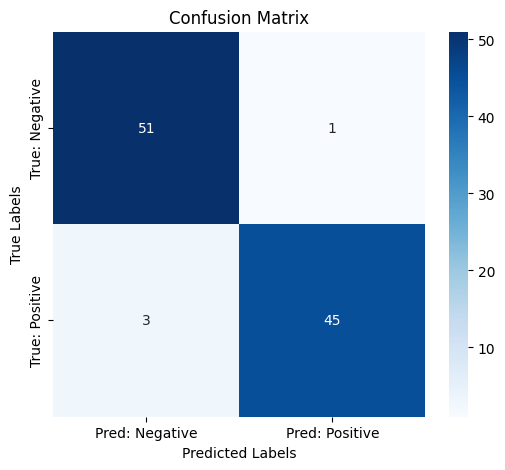

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# Test phase
model.eval()
test_loss = 0.0
correct_predictions = 0
total_predictions = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    with tqdm(total=len(test_loader), desc="Testing") as pbar:
        for video_batch, labels in test_loader:
            video_batch = video_batch.to(device)
            labels = labels.to(device)
            
            outputs = model(video_batch).squeeze()
            outputs = outputs.view_as(labels)
            loss = criterion(outputs, labels.float())
            test_loss += loss.item()
            
            # Collecting predictions and true labels for F1, precision, recall, and confusion matrix
            predictions = (outputs > 0.5).float()
            all_labels.append(labels.cpu().numpy())
            all_predictions.append(predictions.cpu().numpy())
            
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)
            pbar.update(1)

# Calculate the average test loss
history["test_loss"] = test_loss / len(test_loader)

# Calculate accuracy
history["test_accuracy"] = correct_predictions / total_predictions

# Flatten the list of labels and predictions for F1, precision, recall, and confusion matrix
all_labels = np.concatenate(all_labels)
all_predictions = np.concatenate(all_predictions)

# Calculate precision, recall, and F1 score
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

history["test_precision"] = precision
history["test_recall"] = recall
history["test_f1"] = f1
history["test_confusion_matrix"] = conf_matrix

# Print results
print(f"Test Loss: {history['test_loss']:.4f}, Test Accuracy: {history['test_accuracy']:.2%}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Pred: Negative", "Pred: Positive"], yticklabels=["True: Negative", "True: Positive"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
